In [1]:
"""
STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂
Projet Python pour la Data Science - Analyse causale Grenoble & Paris
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
from shapely.geometry import Point, shape
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# ============================================================================
# 0. CHEMINS ET CHARGEMENT DES DONNÉES
# ============================================================================

HERE = Path().resolve()
ROOT = HERE.parent if 'zfe-scm' in str(HERE) else HERE
DATA = ROOT / "data"

print("=" * 80)
print("📊 STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂")
print("=" * 80)

# Charger les métadonnées ZFE
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
zfe_meta['first_date_debut'] = pd.to_datetime(zfe_meta['first_date_debut'])

# Dates de début des ZFE
grenoble_zfe_start = zfe_meta.loc[zfe_meta['publisher_zfe_id'] == 'GRENOBLE', 'first_date_debut'].iloc[0]
paris_zfe_start = zfe_meta.loc[zfe_meta['publisher_zfe_id'] == 'PARIS', 'first_date_debut'].iloc[0]

print(f"\n🎯 Dates clés :")
print(f"  • ZFE Grenoble : {grenoble_zfe_start.date()}")
print(f"  • ZFE Paris : {paris_zfe_start.date()}")

# Charger les données de pollution
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily['date'] = pd.to_datetime(grenoble_daily['date'])

paris_daily = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
paris_daily['date'] = pd.to_datetime(paris_daily['date'])

# Charger les donneurs
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily['date'] = pd.to_datetime(donors_daily['date'])

print(f"\n📁 Données chargées :")
print(f"  • Grenoble : {len(grenoble_daily)} observations, {grenoble_daily['station_id'].nunique()} stations")
print(f"  • Paris : {len(paris_daily)} observations, {paris_daily['station_id'].nunique()} stations")
print(f"  • Donneurs : {len(donors_daily)} observations, {donors_daily['station_id'].nunique()} stations")


📊 STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂

🎯 Dates clés :
  • ZFE Grenoble : 2019-05-02
  • ZFE Paris : 2021-06-01

📁 Données chargées :
  • Grenoble : 5836 observations, 2 stations
  • Paris : 5268 observations, 2 stations
  • Donneurs : 28678 observations, 10 stations



1️⃣ CARTOGRAPHIE AVEC GEOPANDAS
✅ Carte sauvegardée : stats_desc_carte_zfe.png


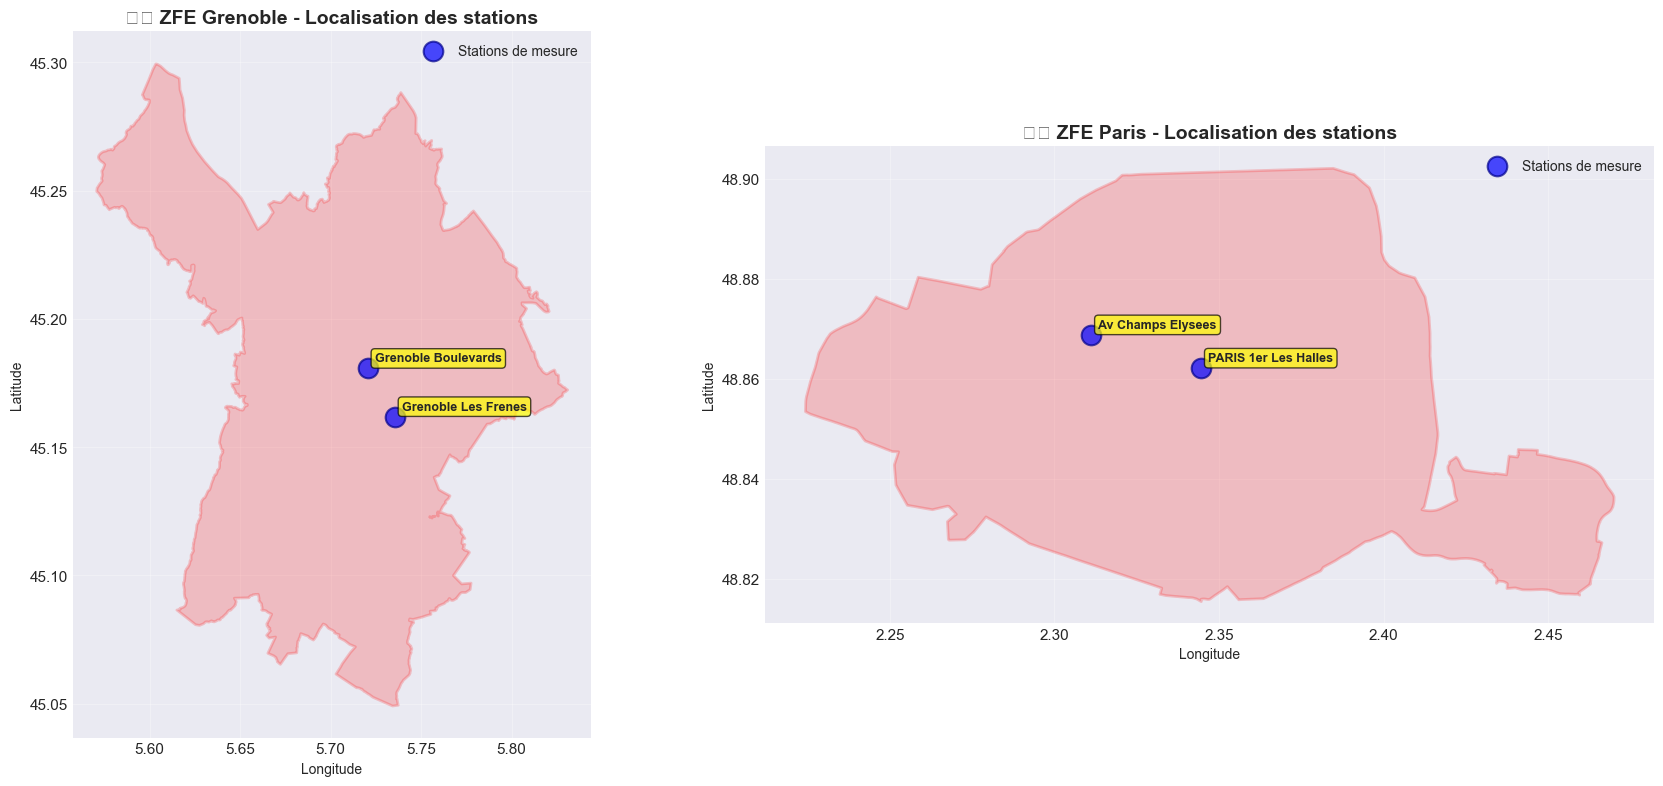

In [2]:
# ============================================================================
# 1. CARTOGRAPHIE - VISUALISATION GÉOGRAPHIQUE DES ZFE ET STATIONS
# ============================================================================

print("\n" + "=" * 80)
print("1️⃣ CARTOGRAPHIE AVEC GEOPANDAS")
print("=" * 80)

# Charger les périmètres ZFE
with open(DATA / "aires.geojson", encoding="utf-8") as f:
    zfe_geojson = json.load(f)

# Créer GeoDataFrame des ZFE
zfe_features = []
for feat in zfe_geojson['features']:
    pub = feat.get('publisher', {})
    zfe_id = pub.get('zfe_id')
    if zfe_id in ['GRENOBLE', 'PARIS']:
        zfe_features.append({
            'zfe_id': zfe_id,
            'nom': pub.get('nom'),
            'geometry': shape(feat['geometry'])
        })

gdf_zfe = gpd.GeoDataFrame(zfe_features, crs="EPSG:4326")

# Créer GeoDataFrame des stations
def create_stations_gdf(df, zfe_name):
    stations = df[['station_id', 'station_name', 'station_env', 'station_influence', 'lat', 'lon']].drop_duplicates()
    stations['geometry'] = stations.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    stations['ville'] = zfe_name
    return gpd.GeoDataFrame(stations, crs="EPSG:4326")

gdf_grenoble = create_stations_gdf(grenoble_daily, 'Grenoble')
gdf_paris = create_stations_gdf(paris_daily, 'Paris')
gdf_stations = pd.concat([gdf_grenoble, gdf_paris], ignore_index=True)

# Créer une carte pour chaque ville
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, (ville, ax) in enumerate(zip(['GRENOBLE', 'PARIS'], axes)):
    # Périmètre ZFE
    zfe_subset = gdf_zfe[gdf_zfe['zfe_id'] == ville]
    zfe_subset.plot(ax=ax, color='red', alpha=0.2, edgecolor='red', linewidth=2, label='Périmètre ZFE')
    
    # Stations
    stations_subset = gdf_stations[gdf_stations['ville'] == ville.capitalize()]
    stations_subset.plot(ax=ax, color='blue', markersize=200, alpha=0.7, 
                         edgecolor='darkblue', linewidth=1.5, label='Stations de mesure')
    
    # Annotations
    for _, station in stations_subset.iterrows():
        ax.annotate(station['station_name'], 
                   xy=(station.geometry.x, station.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_title(f"🗺️ ZFE {ville.capitalize()} - Localisation des stations", fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_carte_zfe.png', dpi=300, bbox_inches='tight')
print("✅ Carte sauvegardée : stats_desc_carte_zfe.png")
plt.show()


2️⃣ ÉVOLUTION TEMPORELLE DU NO₂
✅ Graphique sauvegardé : stats_desc_evolution_temporelle.png


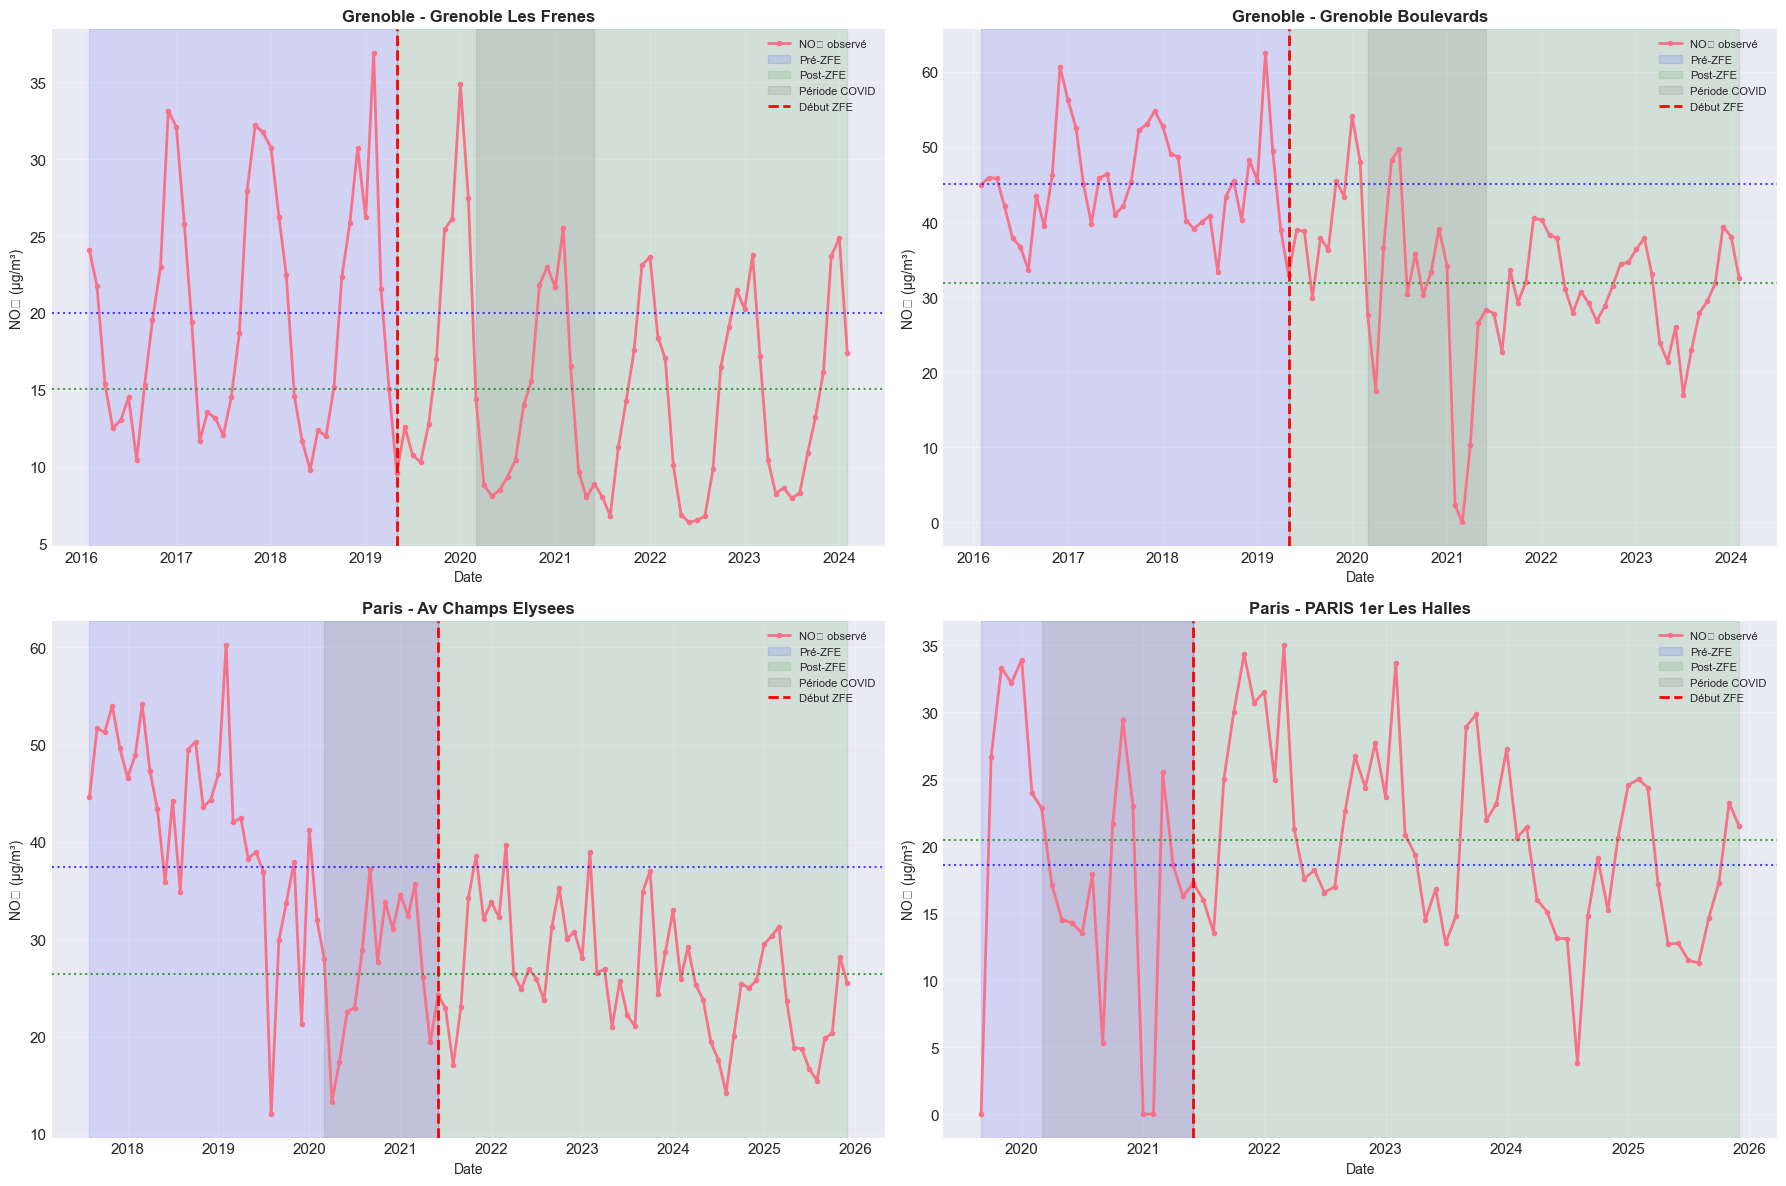

In [3]:
 #============================================================================
# 2. STATISTIQUES TEMPORELLES - ÉVOLUTION DU NO₂
# ============================================================================

print("\n" + "=" * 80)
print("2️⃣ ÉVOLUTION TEMPORELLE DU NO₂")
print("=" * 80)

def prepare_monthly_data(df, zfe_start):
    """Agrégation mensuelle avec marqueur pré/post ZFE"""
    monthly = df.set_index('date').groupby('station_id')['no2_ug_m3'].resample('MS').mean().reset_index()
    monthly['period'] = monthly['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_start else 'Post-ZFE')
    # Exclure période COVID (mars 2020 - juin 2021)
    covid_mask = (monthly['date'] >= '2020-03-01') & (monthly['date'] <= '2021-06-01')
    monthly['period_clean'] = monthly['period'].copy()
    monthly.loc[covid_mask, 'period_clean'] = 'COVID (exclu)'
    return monthly

grenoble_monthly = prepare_monthly_data(grenoble_daily, grenoble_zfe_start)
paris_monthly = prepare_monthly_data(paris_daily, paris_zfe_start)

# Graphique multi-stations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

datasets = [
    (grenoble_monthly, 'Grenoble', grenoble_zfe_start),
    (paris_monthly, 'Paris', paris_zfe_start)
]

for idx, (monthly_df, ville, zfe_date) in enumerate(datasets):
    stations = monthly_df['station_id'].unique()
    
    for i, station_id in enumerate(stations[:2]):  # 2 stations max par ville
        ax = axes[idx * 2 + i]
        station_data = monthly_df[monthly_df['station_id'] == station_id]
        station_name = grenoble_daily[grenoble_daily['station_id'] == station_id]['station_name'].iloc[0] if ville == 'Grenoble' else paris_daily[paris_daily['station_id'] == station_id]['station_name'].iloc[0]
        
        # Ligne temporelle
        ax.plot(station_data['date'], station_data['no2_ug_m3'], 
               linewidth=2, marker='o', markersize=3, label='NO₂ observé')
        
        # Zones colorées
        pre_data = station_data[station_data['period'] == 'Pré-ZFE']
        post_data = station_data[station_data['period'] == 'Post-ZFE']
        
        ax.axvspan(station_data['date'].min(), zfe_date, alpha=0.1, color='blue', label='Pré-ZFE')
        ax.axvspan(zfe_date, station_data['date'].max(), alpha=0.1, color='green', label='Post-ZFE')
        
        # Zone COVID
        ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), 
                  alpha=0.2, color='gray', label='Période COVID')
        
        # Ligne verticale ZFE
        ax.axvline(zfe_date, color='red', linestyle='--', linewidth=2, label=f'Début ZFE')
        
        # Moyennes pré/post
        pre_mean = pre_data['no2_ug_m3'].mean()
        post_mean = post_data['no2_ug_m3'].mean()
        ax.axhline(pre_mean, color='blue', linestyle=':', alpha=0.7)
        ax.axhline(post_mean, color='green', linestyle=':', alpha=0.7)
        
        ax.set_title(f"{ville} - {station_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('NO₂ (µg/m³)', fontsize=10)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_evolution_temporelle.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_evolution_temporelle.png")
plt.show()



3️⃣ COMPARAISONS PRÉ/POST ZFE

📊 TABLEAU RÉCAPITULATIF DES STATISTIQUES
   ville         station_name station_type  pre_mean  post_mean  reduction_pct       p_value
Grenoble  Grenoble Les Frenes         Fond 20.182203  15.080312     -25.279158  4.266285e-38
Grenoble  Grenoble Boulevards       Trafic 45.297119  33.231513     -26.636585 3.923517e-117
   Paris    Av Champs Elysees       Trafic 42.095135  26.396017     -37.294376 4.699024e-152
   Paris PARIS 1er Les Halles         Fond 28.728378  20.445902     -28.830297  1.051356e-18
✅ Tableau sauvegardé : stats_desc_tableau_recapitulatif.csv
✅ Graphique sauvegardé : stats_desc_comparaisons_pre_post.png


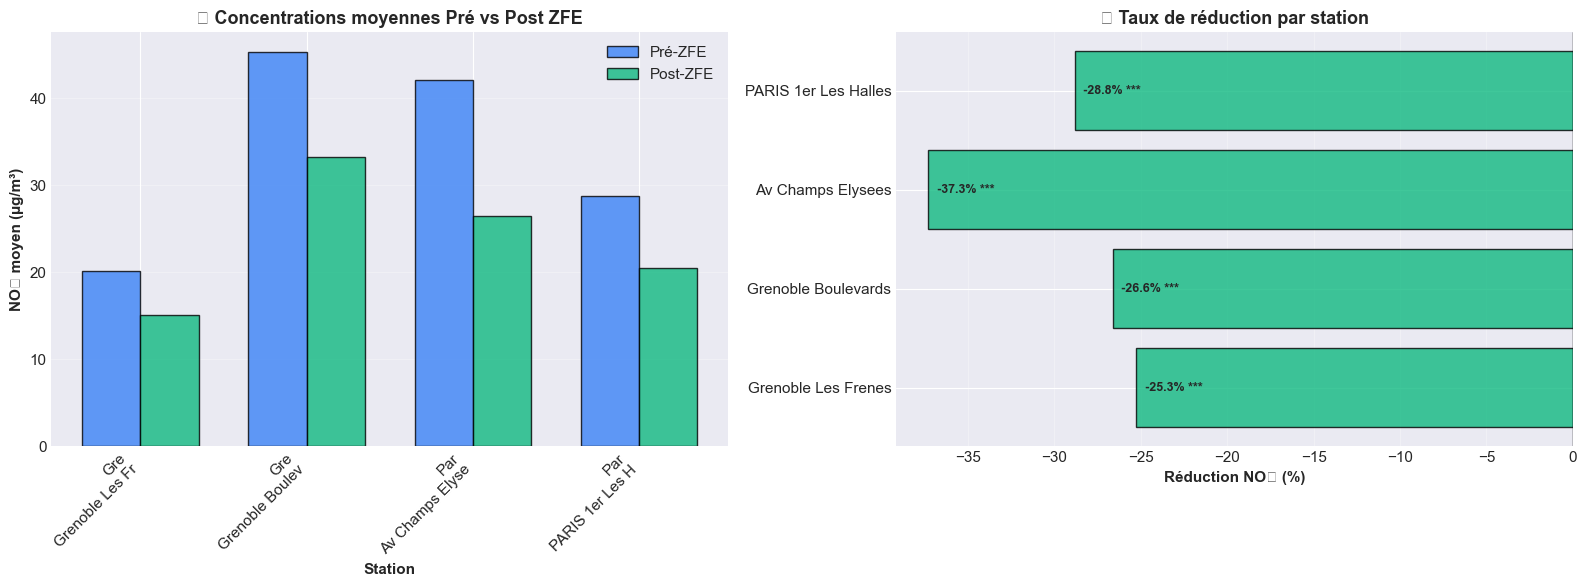

In [9]:
# ============================================================================
# 3. COMPARAISONS PRÉ/POST ZFE - STATISTIQUES DESCRIPTIVES
# ============================================================================

print("\n" + "=" * 80)
print("3️⃣ COMPARAISONS PRÉ/POST ZFE")
print("=" * 80)

def compute_pre_post_stats(df, zfe_start, ville):
    """Calculer statistiques pré/post pour chaque station"""
    results = []
    
    # Exclure COVID
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    
    for station_id in df_clean['station_id'].unique():
        station_data = df_clean[df_clean['station_id'] == station_id]
        station_name = station_data['station_name'].iloc[0]
        station_type = station_data['station_influence'].iloc[0]
        
        # Séparer pré/post
        pre = station_data[station_data['date'] < zfe_start]['no2_ug_m3']
        post = station_data[station_data['date'] >= zfe_start]['no2_ug_m3']
        
        if len(pre) > 30 and len(post) > 30:  # Minimum 30 obs
            # Statistiques descriptives
            pre_mean, pre_std, pre_median = pre.mean(), pre.std(), pre.median()
            post_mean, post_std, post_median = post.mean(), post.std(), post.median()
            
            # Réduction
            reduction_abs = post_mean - pre_mean
            reduction_pct = (reduction_abs / pre_mean) * 100
            
            # Test statistique (t-test)
            t_stat, p_value = stats.ttest_ind(pre, post)
            
            results.append({
                'ville': ville,
                'station_id': station_id,
                'station_name': station_name,
                'station_type': station_type,
                'pre_mean': pre_mean,
                'pre_std': pre_std,
                'pre_median': pre_median,
                'post_mean': post_mean,
                'post_std': post_std,
                'post_median': post_median,
                'reduction_abs': reduction_abs,
                'reduction_pct': reduction_pct,
                't_stat': t_stat,
                'p_value': p_value,
                'n_obs_pre': len(pre),
                'n_obs_post': len(post)
            })
    
    return pd.DataFrame(results)

stats_grenoble = compute_pre_post_stats(grenoble_daily, grenoble_zfe_start, 'Grenoble')
stats_paris = compute_pre_post_stats(paris_daily, paris_zfe_start, 'Paris')
stats_all = pd.concat([stats_grenoble, stats_paris], ignore_index=True)

print("\n📊 TABLEAU RÉCAPITULATIF DES STATISTIQUES")
print("=" * 120)
print(stats_all[['ville', 'station_name', 'station_type', 'pre_mean', 'post_mean', 
                 'reduction_pct', 'p_value']].to_string(index=False))
print("=" * 120)

# Sauvegarder le tableau
stats_all.to_csv(DATA / 'stats_desc_tableau_recapitulatif.csv', index=False)
print("✅ Tableau sauvegardé : stats_desc_tableau_recapitulatif.csv")

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot moyennes
ax1 = axes[0]
x_pos = np.arange(len(stats_all))
width = 0.35
ax1.bar(x_pos - width/2, stats_all['pre_mean'], width, label='Pré-ZFE', 
       color='#3b82f6', alpha=0.8, edgecolor='black')
ax1.bar(x_pos + width/2, stats_all['post_mean'], width, label='Post-ZFE', 
       color='#10b981', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Station', fontweight='bold')
ax1.set_ylabel('NO₂ moyen (µg/m³)', fontweight='bold')
ax1.set_title('📊 Concentrations moyennes Pré vs Post ZFE', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['ville'][:3]}\n{row['station_name'][:15]}" 
                     for _, row in stats_all.iterrows()], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Barplot réductions
ax2 = axes[1]
colors = ['#ef4444' if x > 0 else '#10b981' for x in stats_all['reduction_pct']]
bars = ax2.barh(stats_all['station_name'], stats_all['reduction_pct'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Réduction NO₂ (%)', fontweight='bold')
ax2.set_title('📉 Taux de réduction par station', fontsize=13, fontweight='bold')
ax2.axvline(0, color='black', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# Annotations p-values
for i, (idx, row) in enumerate(stats_all.iterrows()):
    significance = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else 'ns'
    ax2.text(row['reduction_pct'] + 0.5, i, f"{row['reduction_pct']:.1f}% {significance}", 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_comparaisons_pre_post.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_comparaisons_pre_post.png")
plt.show()



4️⃣ DISTRIBUTIONS DES CONCENTRATIONS
✅ Graphique sauvegardé : stats_desc_distributions.png


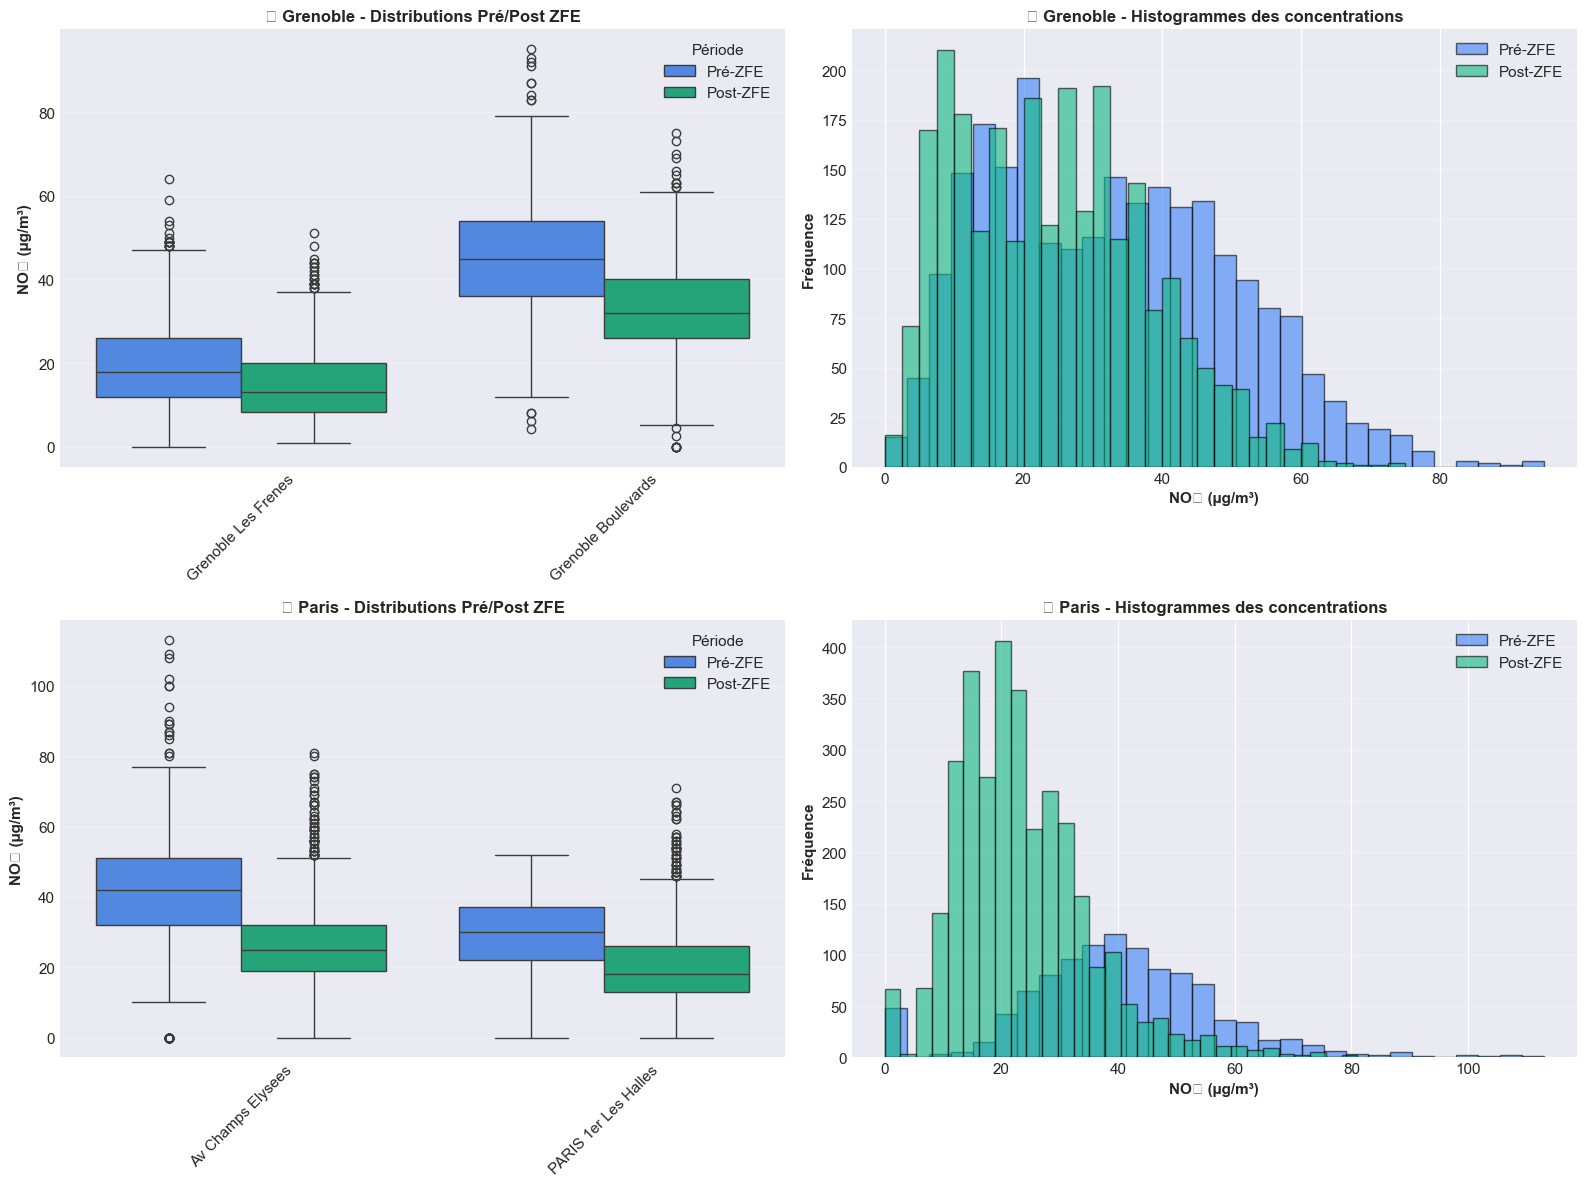

In [10]:
# ============================================================================
# 4. DISTRIBUTIONS ET BOXPLOTS
# ============================================================================

print("\n" + "=" * 80)
print("4️⃣ DISTRIBUTIONS DES CONCENTRATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Données pour plotting
for idx, (df, zfe_date, ville) in enumerate([(grenoble_daily, grenoble_zfe_start, 'Grenoble'),
                                               (paris_daily, paris_zfe_start, 'Paris')]):
    # Exclure COVID
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    df_clean['period'] = df_clean['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_date else 'Post-ZFE')
    
    # Boxplot
    ax1 = axes[idx, 0]
    sns.boxplot(data=df_clean, x='station_name', y='no2_ug_m3', hue='period', ax=ax1, palette=['#3b82f6', '#10b981'])
    ax1.set_title(f'📦 {ville} - Distributions Pré/Post ZFE', fontsize=12, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('NO₂ (µg/m³)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(title='Période')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Histogramme
    ax2 = axes[idx, 1]
    for period, color in [('Pré-ZFE', '#3b82f6'), ('Post-ZFE', '#10b981')]:
        data = df_clean[df_clean['period'] == period]['no2_ug_m3']
        ax2.hist(data, bins=30, alpha=0.6, label=period, color=color, edgecolor='black')
    ax2.set_title(f'📊 {ville} - Histogrammes des concentrations', fontsize=12, fontweight='bold')
    ax2.set_xlabel('NO₂ (µg/m³)', fontweight='bold')
    ax2.set_ylabel('Fréquence', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_distributions.png")
plt.show()


5️⃣ ANALYSE SAISONNIÈRE
✅ Décomposition Grenoble sauvegardée


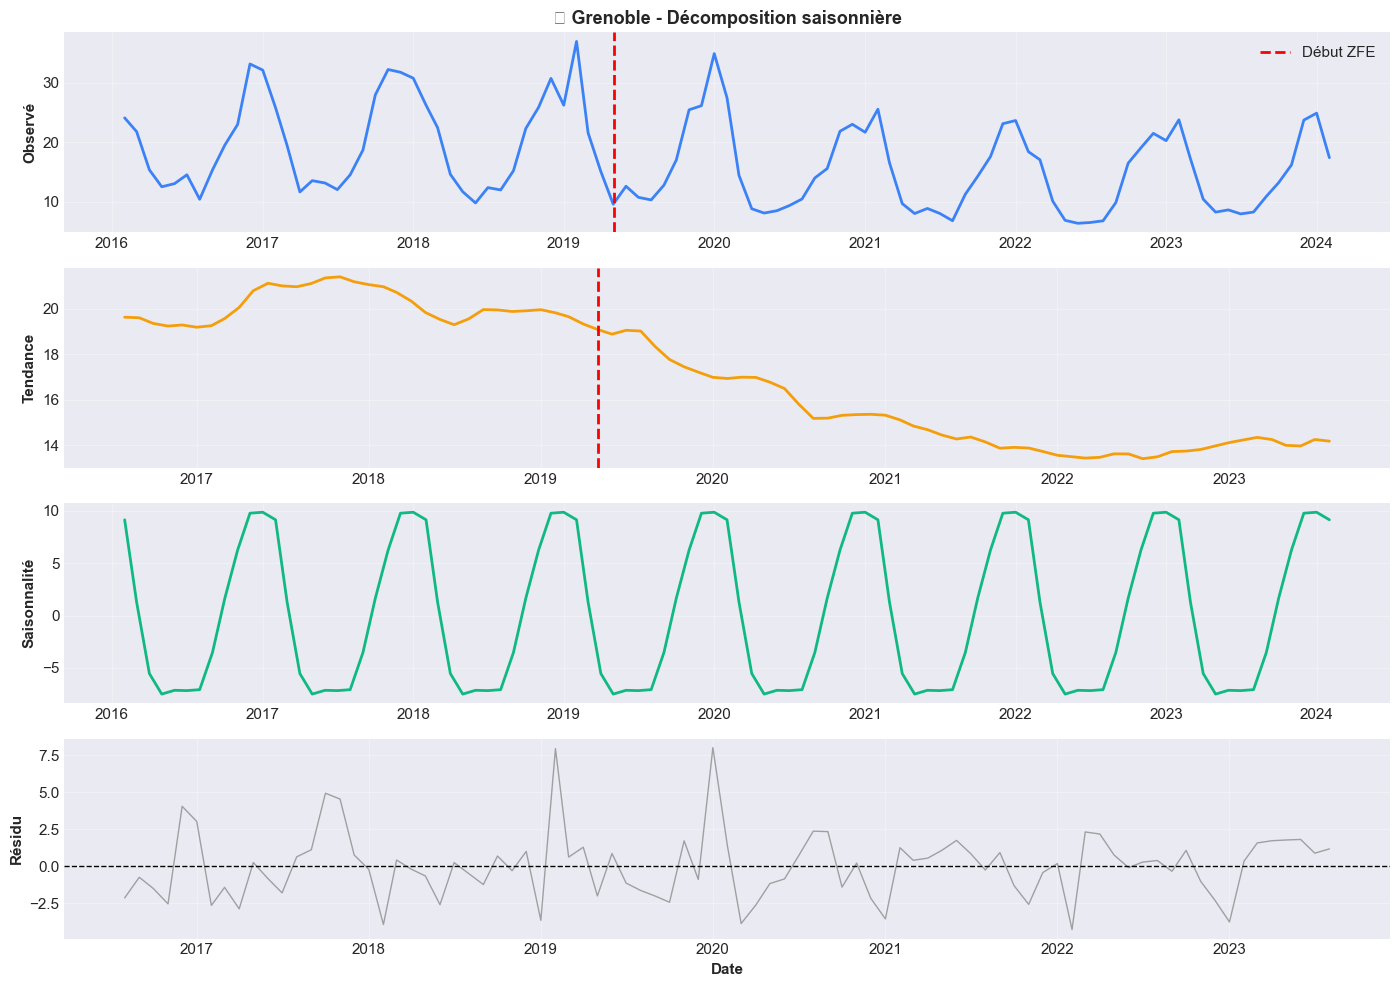

✅ Profils mensuels sauvegardés


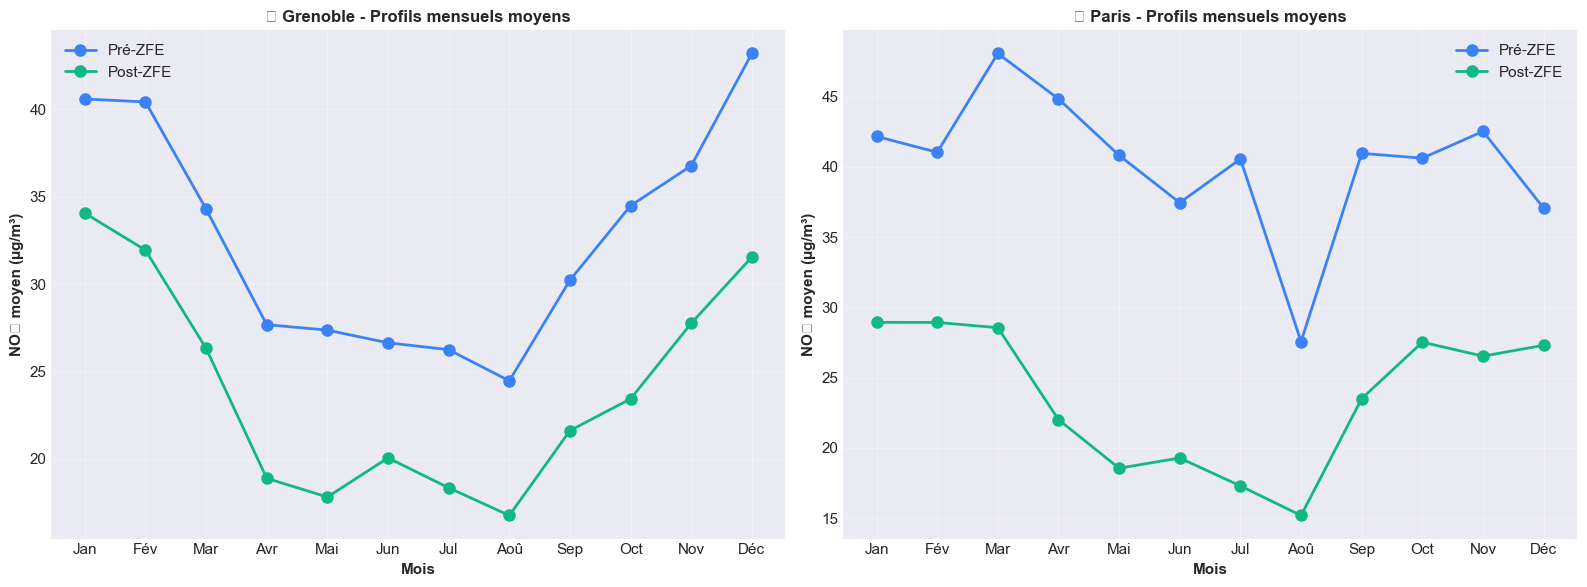

In [11]:
# ============================================================================
# 5. ANALYSE SAISONNIÈRE
# ============================================================================

print("\n" + "=" * 80)
print("5️⃣ ANALYSE SAISONNIÈRE")
print("=" * 80)

def plot_seasonal_patterns(df, zfe_date, ville, station_id):
    """Analyser et tracer les patterns saisonniers"""
    station_data = df[df['station_id'] == station_id].copy()
    station_data = station_data.set_index('date')['no2_ug_m3'].resample('MS').mean()
    
    # Décomposition saisonnière
    if len(station_data) >= 24:  # Minimum 2 ans
        decomposition = seasonal_decompose(station_data, model='additive', period=12)
        
        fig, axes = plt.subplots(4, 1, figsize=(14, 10))
        
        # Série originale
        axes[0].plot(station_data.index, station_data.values, linewidth=2, color='#3b82f6')
        axes[0].axvline(zfe_date, color='red', linestyle='--', linewidth=2, label='Début ZFE')
        axes[0].set_ylabel('Observé', fontweight='bold')
        axes[0].set_title(f'🍂 {ville} - Décomposition saisonnière', fontsize=13, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Tendance
        axes[1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='#f59e0b')
        axes[1].axvline(zfe_date, color='red', linestyle='--', linewidth=2)
        axes[1].set_ylabel('Tendance', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Saisonnalité
        axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='#10b981')
        axes[2].set_ylabel('Saisonnalité', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        # Résidu
        axes[3].plot(decomposition.resid.index, decomposition.resid.values, linewidth=1, color='gray', alpha=0.7)
        axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
        axes[3].set_ylabel('Résidu', fontweight='bold')
        axes[3].set_xlabel('Date', fontweight='bold')
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Grenoble Les Frênes
fig_grenoble = plot_seasonal_patterns(grenoble_daily, grenoble_zfe_start, 'Grenoble', 
                                     grenoble_daily['station_id'].iloc[0])
if fig_grenoble:
    fig_grenoble.savefig(DATA / 'stats_desc_saisonnalite_grenoble.png', dpi=300, bbox_inches='tight')
    print("✅ Décomposition Grenoble sauvegardée")
    plt.show()

# Profils mensuels moyens
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (df, zfe_date, ville) in enumerate([(grenoble_daily, grenoble_zfe_start, 'Grenoble'),
                                               (paris_daily, paris_zfe_start, 'Paris')]):
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['period'] = df_clean['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_date else 'Post-ZFE')
    
    monthly_avg = df_clean.groupby(['month', 'period'])['no2_ug_m3'].mean().reset_index()
    
    ax = axes[idx]
    for period, color in [('Pré-ZFE', '#3b82f6'), ('Post-ZFE', '#10b981')]:
        data = monthly_avg[monthly_avg['period'] == period]
        ax.plot(data['month'], data['no2_ug_m3'], marker='o', linewidth=2, 
               markersize=8, label=period, color=color)
    
    ax.set_title(f'📅 {ville} - Profils mensuels moyens', fontsize=12, fontweight='bold')
    ax.set_xlabel('Mois', fontweight='bold')
    ax.set_ylabel('NO₂ moyen (µg/m³)', fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                       'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_profils_mensuels.png', dpi=300, bbox_inches='tight')
print("✅ Profils mensuels sauvegardés")
plt.show()
